This notebook estimates the effect of a $500 tuition subsidy on average years of schooling based on the parametrization for data set one in KW94 [1].
The results are obtained by parametric bootsrap method accroding to [2, 3]


[1] Keane, M. P. & Wopin, W. I., & Vytlacil, E. J. (1994). 
[The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence.](https://www.jstor.org/stable/2109768)  *The Review of Economics and Statistics, 76(4): 648-672.*

[2] Krinsky, I., & Robb, A. (1986). [On Approximating the Statistical Properties of Elasticities.](https://www.jstor.org/stable/1924536?seq=1) The Review of Economics and Statistics, 68(4), 715-719.

[3] Efron, B., & Tibshirani, R.J. (1994). [An Introduction to the Bootstrap (1st ed.).](https://doi.org/10.1201/9780429246593) Chapman and Hall/CRC. 

In [1]:
import copy
import numpy as np
import pandas as pd
import respy as rp
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

**Step 1**: Generating the **bootstrap samples**: draw  40  samples  of size  100  from  the  parametric estimate of the population   
**Step 2**: Evaluate the **sample mean**(bootstrap replications) corresponding to each bootstrap sample   
**Step 3**: Estimate the **standard  error** by the sample standard deviation of the 40 bootstrap replications

In [2]:
def bs_sampling(n_bs_samples, bs_sample_size, subsidy):
    # load parameters and options corresponding to model
    params, options = rp.get_example_model("kw_94_one", with_data=False)

    # Here we need 40 samples of 100 people. To process this, we genetate 4000 individuals and then
    # split them to 40 equally-sized samples with 100 individuals in each sample.
    options["simulation_agents"] = n_bs_samples * bs_sample_size

    # get simulate function
    simulate = rp.get_simulate_func(params, options)

    # get simulated results without tuition subsidy
    df_no_ts = simulate(params)

    # get simulated results with $500 tuition subsidy
    ts_params = params.copy()
    ts_params.loc[("nonpec_edu", "at_least_twelve_exp_edu"),
                  "value"] += subsidy
    df_ts = simulate(ts_params)

    # assign bootstrap sample number
    for df in [df_no_ts, df_ts]:
        df["sample_num"] = pd.cut(
            df.index.get_level_values(0), bins=n_bs_samples, labels=np.arange(1, n_bs_samples+1)
        )

    # Calculate mean end-of-life schooling
    columns = ["sample_num", "Experience_Edu"]
    mean_edu_no_ts = (
        df_no_ts[(df_no_ts.index.get_level_values(1) == 39)
                 ][columns].groupby("sample_num").mean()
    )
    mean_edu_ts = (
        df_ts[(df_ts.index.get_level_values(1) == 39)
              ][columns].groupby("sample_num").mean()
    )
    # Calculate the difference of mean final schooling with and without tuition subsidy.
    diff_edu = (mean_edu_ts.subtract(
        mean_edu_no_ts).reset_index().set_index("sample_num"))

    return diff_edu

#### 40 bootsrap samples of size 100

In [3]:
diff_edu = bs_sampling(n_bs_samples=40, bs_sample_size=100, subsidy=500)

mean and standard error

In [4]:
mean_diff_edu, std_diff_edu = diff_edu.agg(["mean", "std"])["Experience_Edu"]
mean_diff_edu, std_diff_edu

(1.4707499999999998, 0.19033556736755294)

95% confidence interval

In [5]:
n_samples = len(diff_edu)

sigma = std_diff_edu/math.sqrt(n_samples)  # Standard deviation estimate

stats.t.interval(alpha = 0.95,              # Confidence level
                 df= n_samples - 1,          # Degrees of freedom
                 loc = mean_diff_edu,        # Sample mean
                 scale = sigma)             # Standard deviation estimate

(1.4098777326555625, 1.531622267344437)

plot

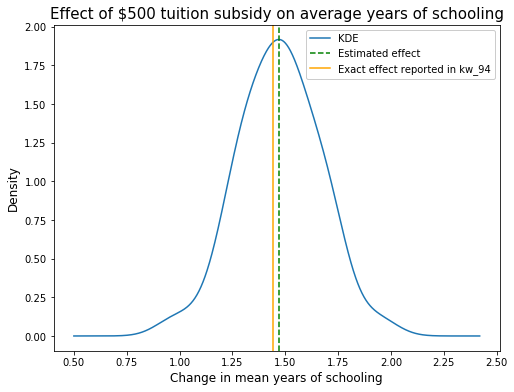

In [6]:
exact_effect_edu = 1.44 # The exact solution reported in kw97,table 9

fig, ax = plt.subplots(figsize=(8,6))
ax = diff_edu["Experience_Edu"].plot(kind="density",label="KDE")
ax.axvline(mean_diff_edu, color="green", linestyle="--", label="Estimated effect")
ax.axvline(exact_effect_edu, color="orange", linestyle="-", label="Exact effect reported in kw_94")
ax.set_xlabel("Change in mean years of schooling",fontsize=12)
ax.set_ylabel("Density",fontsize=12)
ax.set_title("Effect of $500 tuition subsidy on average years of schooling",fontsize=15)
ax.legend(loc='upper right', framealpha=1, frameon=True)

#### Check convergence

In [15]:
# from 20 to 200 samples
n_sample_list = np.arange(10,210,10)
mean = [bs_sampling(n_bs_samples=n,bs_sample_size=100,subsidy=500).agg(["mean", "std"])["Experience_Edu"][0] for n in n_sample_list]

Text(0, 0.5, 'change of mean schooling')

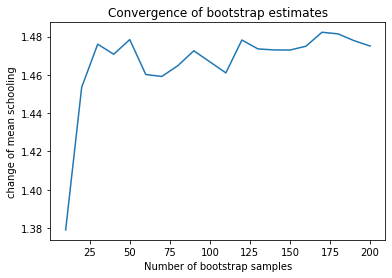

In [21]:
fig, ax = plt.subplots()
ax.plot(n_sample_list, mean)
ax.set_title("Convergence of bootstrap estimates", fontsize=12)
ax.set_xlabel("Number of bootstrap samples",fontsize=10)
ax.set_ylabel("change of mean schooling", fontsize=10)